# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [28]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor, SYSIDRandomizedSearchCV

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score



#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [29]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [30]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


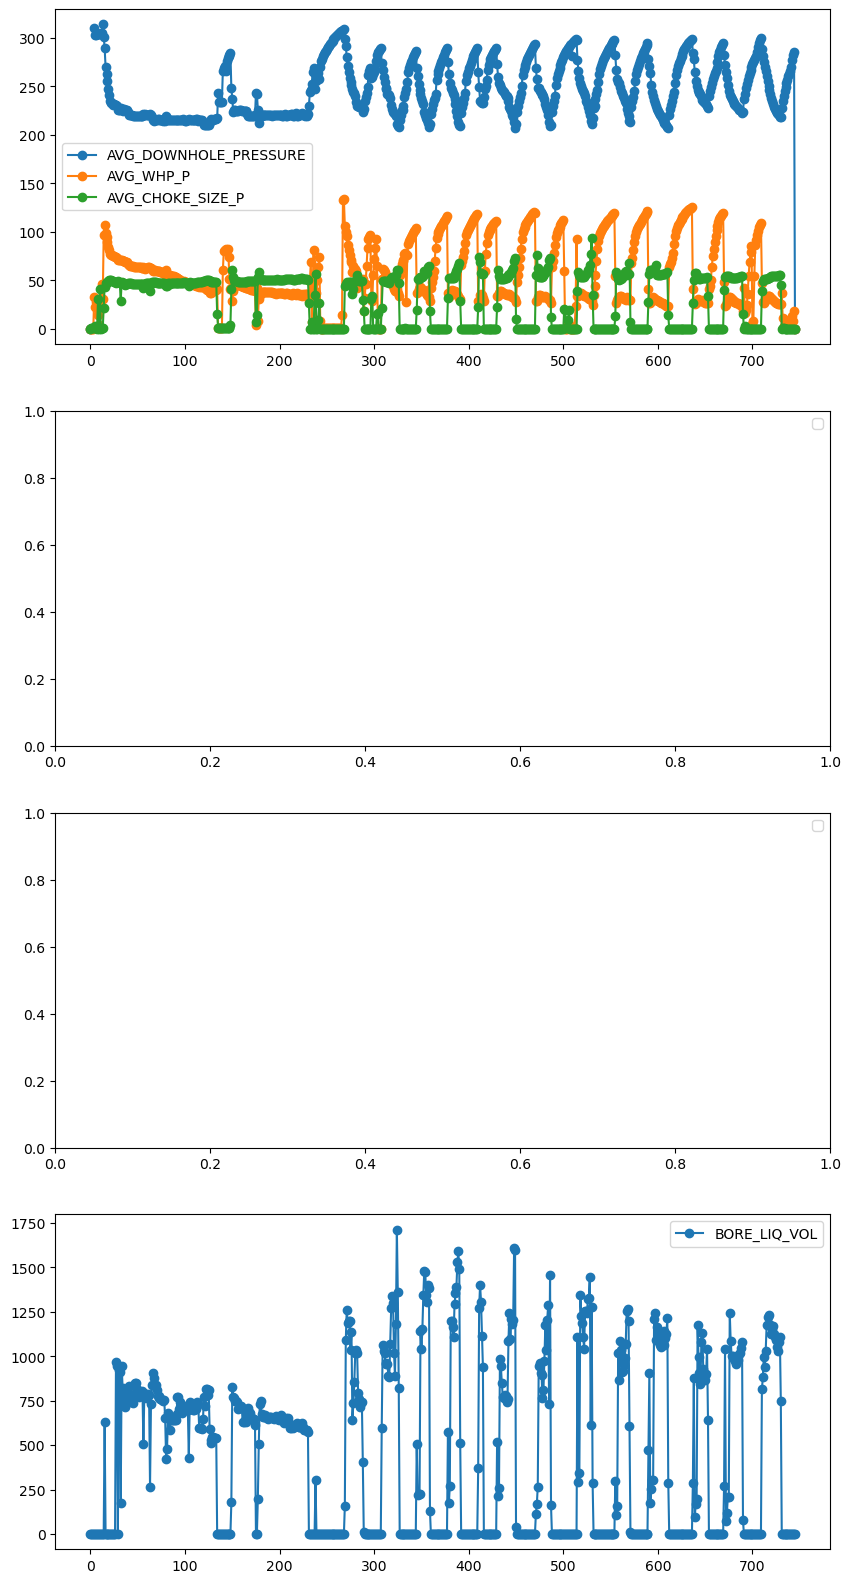

In [31]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'AVG_DOWNHOLE_PRESSURE',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [32]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [33]:
p_train = 0.8 #80% treino

### 1.2 - Separando os conjuntos

In [34]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [35]:
print(
    X1_tr.shape,
    X1_te.shape
)

(574, 3) (144, 3)


In [36]:
y_scale = MinMaxScaler()
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [37]:
models = [
    ('LinReg',  LinearRegression(copy_X=True)),
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

n_models = len(models)

In [38]:
parameters = [
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'positive'            : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [39]:
t_tr = np.arange(570)
tmax = np.max(t_tr)
nfolds = 3
rkf = [
    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
]

In [40]:
results = {
    'MODEL':[],
    'R2 TRAIN':[],
    'R2 TEST':[],
    'MODEL OBJ':[],
    'PARS':[]
}

Iniciando avaliação do modelo: LinReg


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



    Tempo de execução: 0:00:00.263009
    Minimum  error: -0.4561872165826683
    Maximum  error: 0.4654711507449602
    R2 score (Train): 0.5236436789289469
    R2 score (Test): 0.6263887191916071

    Resultados dos parâmetros:
        Parâmetro positive: True

Iniciando avaliação do modelo: SVM


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversio


    Tempo de execução: 0:00:00.632199
    Minimum  error: -0.4294912095189089
    Maximum  error: 0.5299985539315561
    R2 score (Train): 0.5520047531362418
    R2 score (Test): 0.6206168896210709

    Resultados dos parâmetros:
        Parâmetro C: 0.029318300850433562
        Parâmetro degree: 4
        Parâmetro gamma: 0.43099188995716126
        Parâmetro kernel: poly

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:00.202628
    Minimum  error: -0.7089046524047441
    Maximum  error: 0.5747100612132401
    R2 score (Train): 0.47128348912709794
    R2 score (Test): -0.3452231969385846

    Resultados dos parâmetros:
        Parâmetro n_neighbors: 11
        Parâmetro weights: distance

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:00.171379
    Minimum  error: -0.6726282350826742
    Maximum  error: 0.26609719991238323
    R2 score (Train): -0.21146693621040313
    R2 score (Test): -0.5169343607028949

    Resultados dos parâmetros:
        Parâme

/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/


    Tempo de execução: 0:00:02.833166
    Minimum  error: -0.5569499211935014
    Maximum  error: 0.3597720628877217
    R2 score (Train): 0.4181269130669767
    R2 score (Test): 0.3781761655434288

    Resultados dos parâmetros:
        Parâmetro max_depth: 8
        Parâmetro max_features: 0.9914967319021909
        Parâmetro max_leaf_nodes: 108
        Parâmetro min_samples_leaf: 10
        Parâmetro min_samples_split: 18
        Parâmetro n_estimators: 45



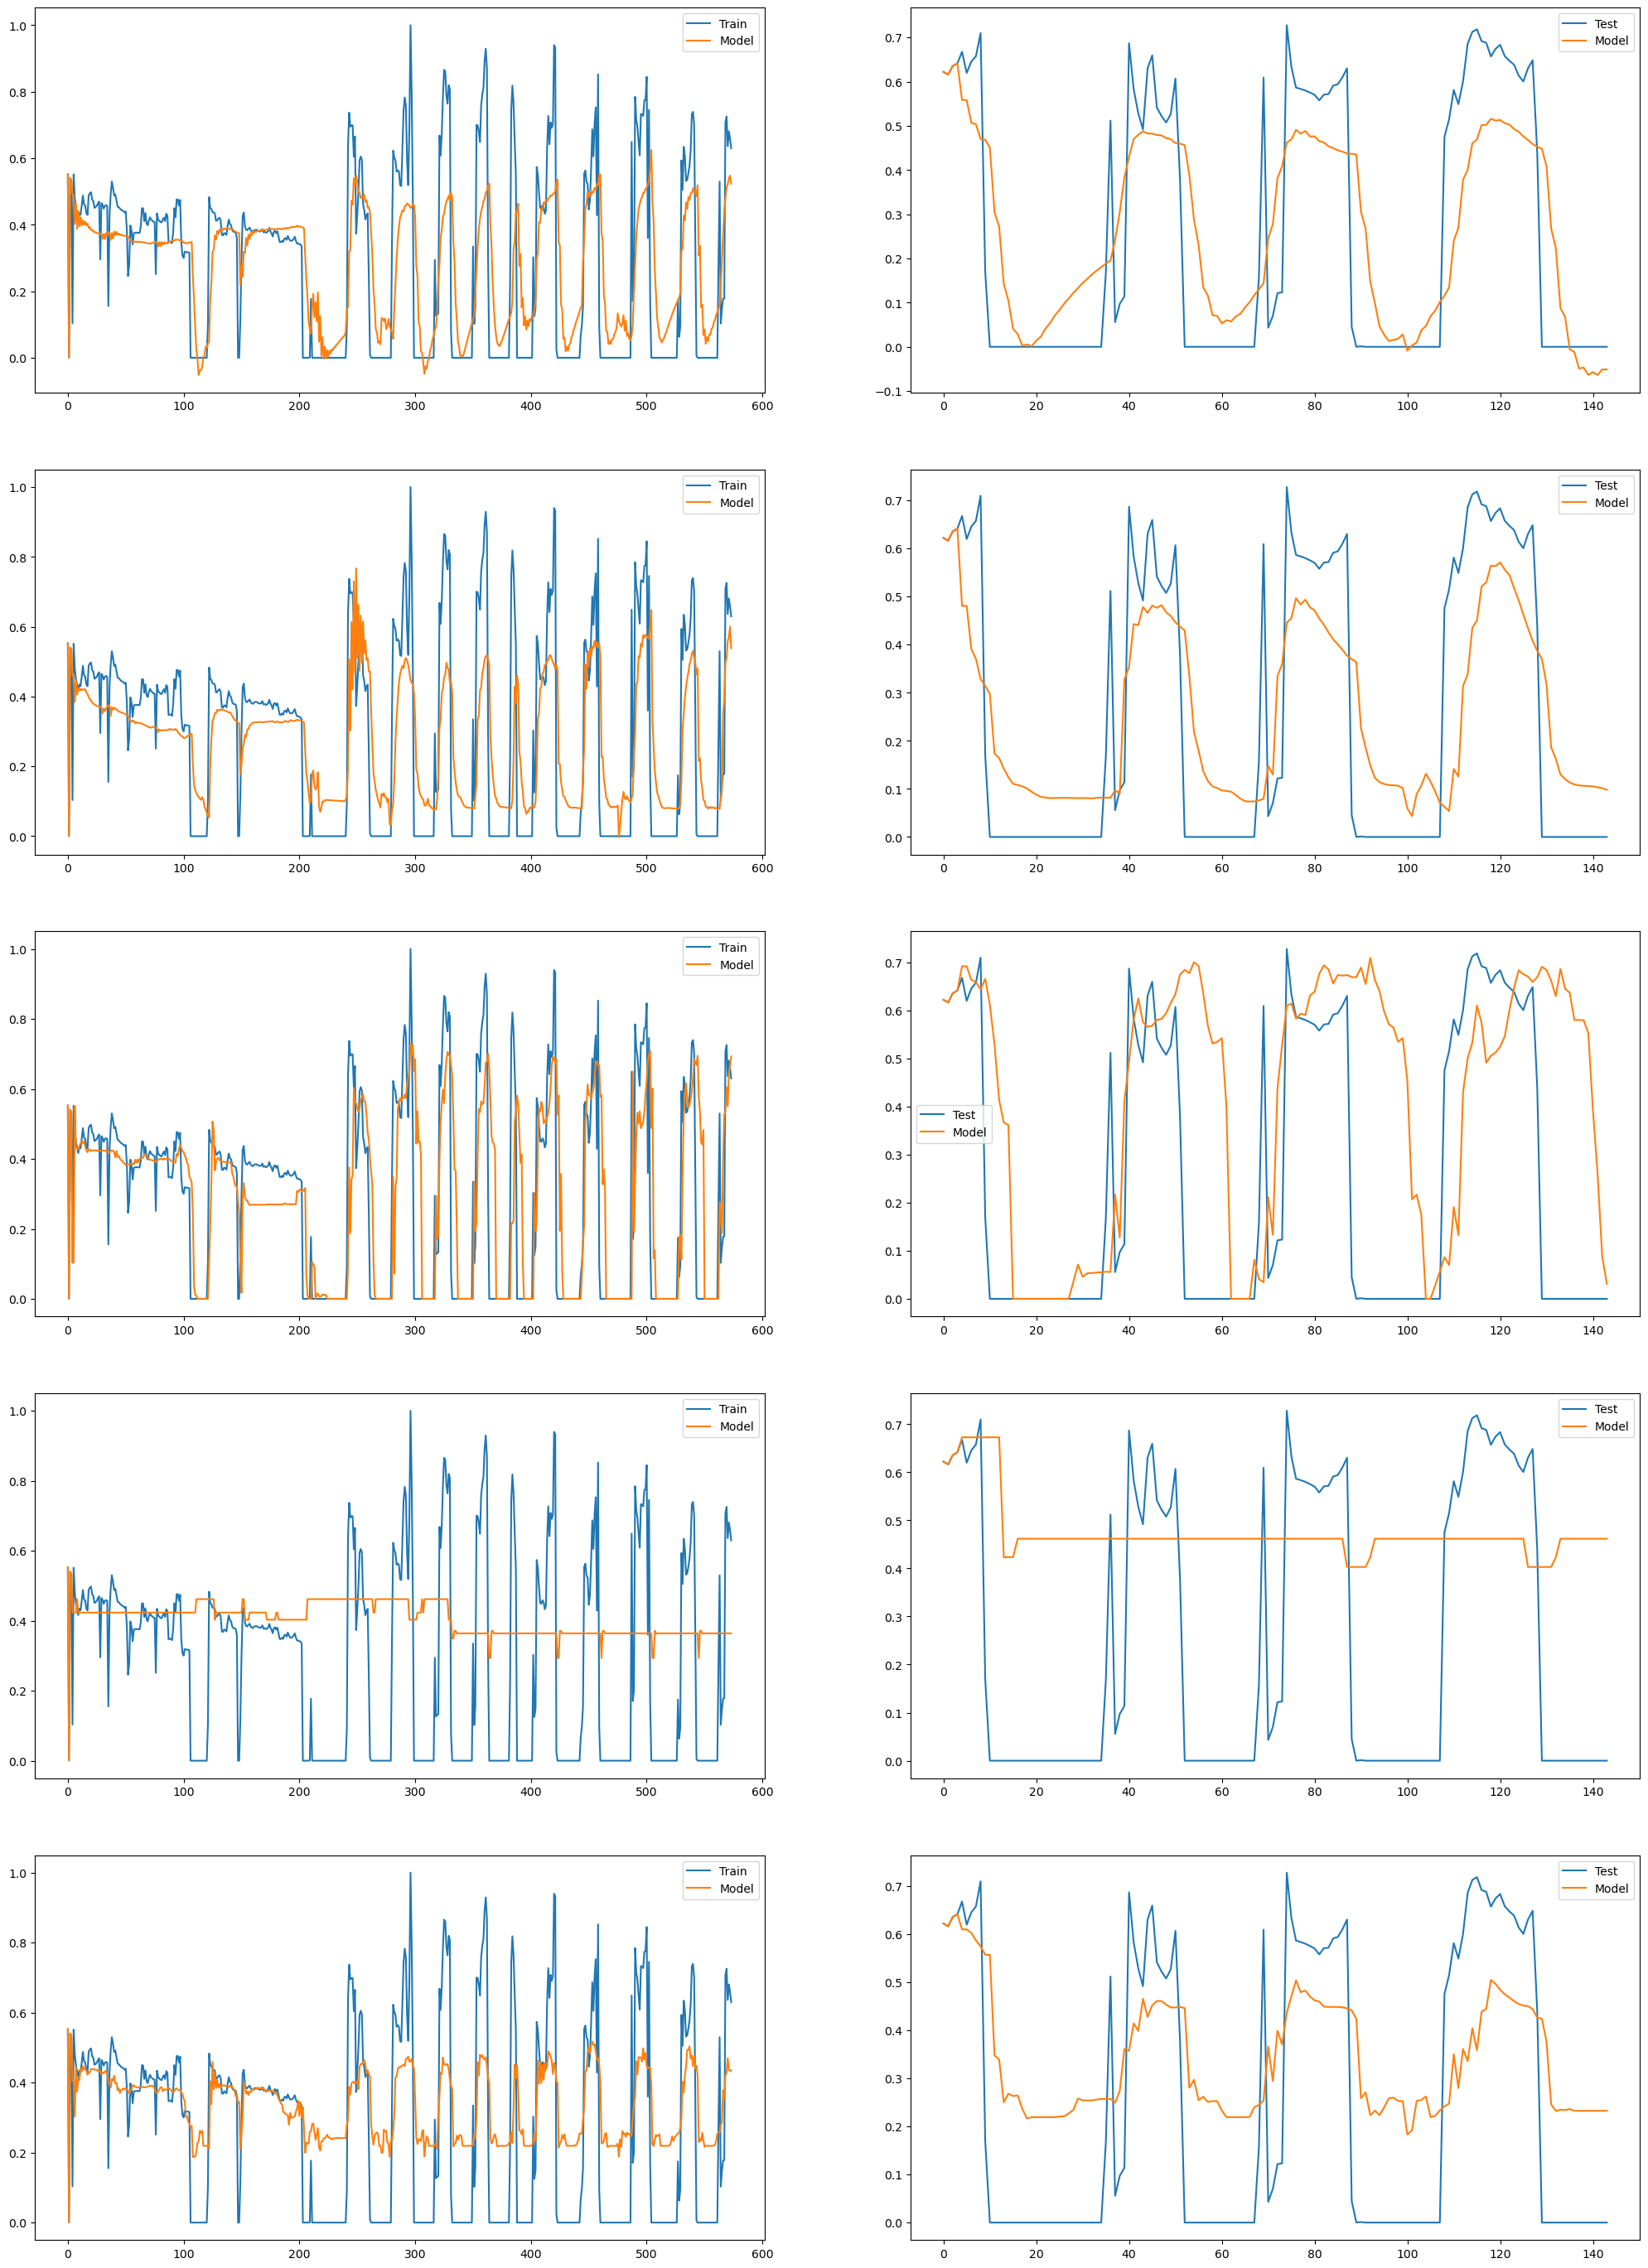

In [41]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    model_bin = model[1]
    print('Iniciando avaliação do modelo: {}'.format(model_name))

    rdmsearch = RandomizedSearchCV(model_bin, verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=4, ny=4,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        expansor=PolynomialFeatures(degree=1)
        )
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
        
    sidmodel.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    error = (y_te - sidmodel.predict(X1_te, y=y_te))
    print('    Minimum  error:', error.min())
    print('    Maximum  error:', error.max())
    r2_tr = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
    r2_te = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
    print('    R2 score (Train):', r2_tr)
    print('    R2 score (Test):', r2_te)
    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr), label='Model')
    ax[0].legend()
    hist = ax[1].plot(y_te, label='Test')
    hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te), label='Model')
    ax[1].legend()
    print()
    print('    Resultados dos parâmetros:')
    for par in sidmodel.estimator.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, sidmodel.estimator.best_params_[par]))  
    print()
    results['MODEL'].append(model_name)
    results['R2 TRAIN'].append(r2_tr)
    results['R2 TEST'].append(r2_te)
    results['MODEL OBJ'].append(sidmodel)
    results['PARS'].append(sidmodel.estimator.best_params_)

In [42]:
pd.DataFrame(results)

,MODEL,R2 TRAIN,R2 TEST,MODEL OBJ,PARS
0,LinReg,0.523644,0.626389,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
1,SVM,0.552005,0.620617,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 0.029318300850433562, 'degree': 4, 'gamm..."
2,KNN,0.471283,-0.345223,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 11, 'weights': 'distance'}"
3,DT,-0.211467,-0.516934,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 12, 'max_features': 0.7373326030..."
4,RF,0.418127,0.378176,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 8, 'max_features': 0.99149673190..."
